# Mini-Project 1: Machine Learning 101

Christian Martel (260867191)

Luka Loignon (260871296)

Marie Guertin (260870552)

# PART I: Adult Dataset

Prediction task is to determine whether someone makes over 50K a year.
https://archive.ics.uci.edu/ml/datasets/Adult

## Imports and Setup

In [1]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
%matplotlib notebook
%matplotlib inline

# other py files
import my_validation
import my_preprocessing

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
np.random.seed(1234)

## Data Preprocessing

### 1. Import Data

In [2]:
columns = ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'salary']
train_df = pd.read_csv("data/adult.data", usecols = range(15), names = columns)
test_df = pd.read_csv("data/adult.test", usecols = range(15), names = columns)
display(train_df)
display(test_df)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K
32557,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K
32558,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K
32559,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,<=50K


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
0,|1x3 Cross validator,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,25,Private,226802.0,11th,7.0,Never-married,Machine-op-inspct,Own-child,Black,Male,0.0,0.0,40.0,United-States,<=50K.
2,38,Private,89814.0,HS-grad,9.0,Married-civ-spouse,Farming-fishing,Husband,White,Male,0.0,0.0,50.0,United-States,<=50K.
3,28,Local-gov,336951.0,Assoc-acdm,12.0,Married-civ-spouse,Protective-serv,Husband,White,Male,0.0,0.0,40.0,United-States,>50K.
4,44,Private,160323.0,Some-college,10.0,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688.0,0.0,40.0,United-States,>50K.
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16277,39,Private,215419.0,Bachelors,13.0,Divorced,Prof-specialty,Not-in-family,White,Female,0.0,0.0,36.0,United-States,<=50K.
16278,64,?,321403.0,HS-grad,9.0,Widowed,?,Other-relative,Black,Male,0.0,0.0,40.0,United-States,<=50K.
16279,38,Private,374983.0,Bachelors,13.0,Married-civ-spouse,Prof-specialty,Husband,White,Male,0.0,0.0,50.0,United-States,<=50K.
16280,44,Private,83891.0,Bachelors,13.0,Divorced,Adm-clerical,Own-child,Asian-Pac-Islander,Male,5455.0,0.0,40.0,United-States,<=50K.


### Check all unique values per feature

It is observed that age in the test dataset is in string format. It should be convert to int format.

It is observed that unknown values are represented by '?'. These values should be impute.

In [3]:
# print unique values for each column
print("TEST DATASET")
for c in test_df.columns:
    print("{c}: ".format(c=c), test_df[c].unique())
    
print("\nTRAIN DATASET")
for c in train_df.columns:
    print("{c}: ".format(c=c), train_df[c].unique())

TEST DATASET
age:  ['|1x3 Cross validator' '25' '38' '28' '44' '18' '34' '29' '63' '24' '55'
 '65' '36' '26' '58' '48' '43' '20' '37' '40' '72' '45' '22' '23' '54'
 '32' '46' '56' '17' '39' '52' '21' '42' '33' '30' '47' '41' '19' '69'
 '50' '31' '59' '49' '51' '27' '57' '61' '64' '79' '73' '53' '77' '80'
 '62' '35' '68' '66' '75' '60' '67' '71' '70' '90' '81' '74' '78' '82'
 '83' '85' '76' '84' '89' '88' '87']
workclass:  [nan ' Private' ' Local-gov' ' ?' ' Self-emp-not-inc' ' Federal-gov'
 ' State-gov' ' Self-emp-inc' ' Without-pay' ' Never-worked']
fnlwgt:  [    nan 226802.  89814. ... 349230. 321403.  83891.]
education:  [nan ' 11th' ' HS-grad' ' Assoc-acdm' ' Some-college' ' 10th'
 ' Prof-school' ' 7th-8th' ' Bachelors' ' Masters' ' Doctorate' ' 5th-6th'
 ' Assoc-voc' ' 9th' ' 12th' ' 1st-4th' ' Preschool']
education-num:  [nan  7.  9. 12. 10.  6. 15.  4. 13. 14. 16.  3. 11.  5.  8.  2.  1.]
marital-status:  [nan ' Never-married' ' Married-civ-spouse' ' Widowed' ' Divorced'
 ' Sepa

### 2. Clean up Data

1. Categorical data is not stripped, labels contain left white spaces.

2. First row of test data set is junk data

3. Age column in test data set are strings, should be convert to int.



In [4]:
# 1.
train_df = my_preprocessing.strip_labels(train_df)
test_df = my_preprocessing.strip_labels(test_df)

# 2.
test_df.drop(labels=0, inplace = True)

# 3.
test_df['age'] = test_df['age'].astype('int64', errors='ignore')



### 3. Remove Useless Columns

From the imported datasets, we observe that the capital-gain and capital-loss columns contain mostly zeros. These columns are not important features so they will be removed.

In [5]:
# remove columns with too much missing data
train_df.drop(columns = ['capital-gain', 'capital-loss'], inplace = True)
test_df.drop(columns = ['capital-gain', 'capital-loss'], inplace = True)

### 4. Data Imputation

For continuous data: replace Nan values or invalid values with mean value of column

For categorical data: replace Nan values or invalid values with most occurring features

In [6]:
# map the invalid entries for each column
invalid_entries_dict = {
    'age':[],
    'workclass':['?'],
    'fnlwgt':[],
    'education':[],
    'education-num':[],
    'marital-status':[],
    'occupation':['?'],
    'relationship':[],
    'race':[],
    'sex':[],
    'hours-per-week':[],
    'native-country':['?']
}
train_df = my_preprocessing.imputation(train_df, invalid_entries_dict)
test_df = my_preprocessing.imputation(test_df, invalid_entries_dict)

### 5. Categorical Features One-Hot-Encoding 

In [7]:
# pop prediction column
y_train, y_test = train_df.pop('salary'), test_df.pop('salary')

# one-hot-encode categorical features
train_df = my_preprocessing.ohe(train_df)
test_df = my_preprocessing.ohe(test_df)
        
# add back prediction column
train_df, test_df = pd.concat([train_df, y_train],axis=1), pd.concat([test_df, y_test],axis=1)
display(train_df)
display(test_df)

,age,fnlwgt,education-num,hours-per-week,workclass_Federal-gov,workclass_Local-gov,workclass_Never-worked,workclass_Private,workclass_Self-emp-inc,workclass_Self-emp-not-inc,workclass_State-gov,workclass_Without-pay,education_10th,education_11th,education_12th,education_1st-4th,education_5th-6th,education_7th-8th,education_9th,education_Assoc-acdm,education_Assoc-voc,education_Bachelors,education_Doctorate,education_HS-grad,education_Masters,education_Preschool,education_Prof-school,education_Some-college,marital-status_Divorced,marital-status_Married-AF-spouse,marital-status_Married-civ-spouse,marital-status_Married-spouse-absent,marital-status_Never-married,marital-status_Separated,marital-status_Widowed,occupation_Adm-clerical,occupation_Armed-Forces,occupation_Craft-repair,occupation_Exec-managerial,occupation_Farming-fishing,occupation_Handlers-cleaners,occupation_Machine-op-inspct,occupation_Other-service,occupation_Priv-house-serv,occupation_Prof-specialty,occupation_Protective-serv,occupation_Sales,occupation_Tech-support,occupation_Transport-moving,relationship_Husband,relationship_Not-in-family,relationship_Other-relative,relationship_Own-child,relationship_Unmarried,relationship_Wife,race_Amer-Indian-Eskimo,race_Asian-Pac-Islander,race_Black,race_Other,race_White,sex_Female,sex_Male,native-country_Cambodia,native-country_Canada,native-country_China,native-country_Columbia,native-country_Cuba,native-country_Dominican-Republic,native-country_Ecuador,native-country_El-Salvador,native-country_England,native-country_France,native-country_Germany,native-country_Greece,native-country_Guatemala,native-country_Haiti,native-country_Holand-Netherlands,native-country_Honduras,native-country_Hong,native-country_Hungary,native-country_India,native-country_Iran,native-country_Ireland,native-country_Italy,native-country_Jamaica,native-country_Japan,native-country_Laos,native-country_Mexico,native-country_Nicaragua,native-country_Outlying-US(Guam-USVI-etc),native-country_Peru,native-country_Philippines,native-country_Poland,native-country_Portugal,native-country_Puerto-Rico,native-country_Scotland,native-country_South,native-country_Taiwan,native-country_Thailand,native-country_Trinadad&Tobago,native-country_United-States,native-country_Vietnam,native-country_Yugoslavia,salary
0,39,77516,13,40,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,<=50K
1,50,83311,13,13,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,<=50K
2,38,215646,9,40,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,<=50K
3,53,234721,7,40,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,<=50K
4,28,338409,13,40,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27,257302,12,38,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,

,age,fnlwgt,education-num,hours-per-week,workclass_Federal-gov,workclass_Local-gov,workclass_Never-worked,workclass_Private,workclass_Self-emp-inc,workclass_Self-emp-not-inc,workclass_State-gov,workclass_Without-pay,education_10th,education_11th,education_12th,education_1st-4th,education_5th-6th,education_7th-8th,education_9th,education_Assoc-acdm,education_Assoc-voc,education_Bachelors,education_Doctorate,education_HS-grad,education_Masters,education_Preschool,education_Prof-school,education_Some-college,marital-status_Divorced,marital-status_Married-AF-spouse,marital-status_Married-civ-spouse,marital-status_Married-spouse-absent,marital-status_Never-married,marital-status_Separated,marital-status_Widowed,occupation_Adm-clerical,occupation_Armed-Forces,occupation_Craft-repair,occupation_Exec-managerial,occupation_Farming-fishing,occupation_Handlers-cleaners,occupation_Machine-op-inspct,occupation_Other-service,occupation_Priv-house-serv,occupation_Prof-specialty,occupation_Protective-serv,occupation_Sales,occupation_Tech-support,occupation_Transport-moving,relationship_Husband,relationship_Not-in-family,relationship_Other-relative,relationship_Own-child,relationship_Unmarried,relationship_Wife,race_Amer-Indian-Eskimo,race_Asian-Pac-Islander,race_Black,race_Other,race_White,sex_Female,sex_Male,native-country_Cambodia,native-country_Canada,native-country_China,native-country_Columbia,native-country_Cuba,native-country_Dominican-Republic,native-country_Ecuador,native-country_El-Salvador,native-country_England,native-country_France,native-country_Germany,native-country_Greece,native-country_Guatemala,native-country_Haiti,native-country_Honduras,native-country_Hong,native-country_Hungary,native-country_India,native-country_Iran,native-country_Ireland,native-country_Italy,native-country_Jamaica,native-country_Japan,native-country_Laos,native-country_Mexico,native-country_Nicaragua,native-country_Outlying-US(Guam-USVI-etc),native-country_Peru,native-country_Philippines,native-country_Poland,native-country_Portugal,native-country_Puerto-Rico,native-country_Scotland,native-country_South,native-country_Taiwan,native-country_Thailand,native-country_Trinadad&Tobago,native-country_United-States,native-country_Vietnam,native-country_Yugoslavia,salary
1,25,226802.0,7.0,40.0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,<=50K.
2,38,89814.0,9.0,50.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,<=50K.
3,28,336951.0,12.0,40.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,>50K.
4,44,160323.0,10.0,40.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,>50K.
5,18,103497.0,10.0,30.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,<=50K.
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16277,39,215419.0,13.0,36.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

### 6. Split Train Test Sets

In [8]:
train, test = train_df.to_numpy(), test_df.to_numpy()

# random permutations of indices
inds = np.random.permutation(range(train.shape[0]))

# split into features set and prediction set
x_train, y_train = train[inds, :-1], train[inds, -1]
x_test, y_test = test[:, :-1], test[:, -1]

### 7. Chi-Squared Feature Selection

Method that allows to select the K most important features of a dataset, features to which the prediction variable is the most dependent.

We will select the 10 most important features.

In [9]:
from sklearn.feature_selection import SelectKBest, chi2
fs = SelectKBest(score_func=chi2, k=10)
fs.fit(x_train, y_train)
x_train = fs.transform(x_train)

fs.fit(x_test, y_test)
x_test = fs.transform(x_test)

## Experiments

### 1. KNN

In [10]:
from sklearn.neighbors import KNeighborsClassifier

# number of folds for L-fold cross-validation
L = 5

# range of number of nearest neighbors (K)
K_list = range(1,16) # [1,2,...,15]

#### Cross-Validation

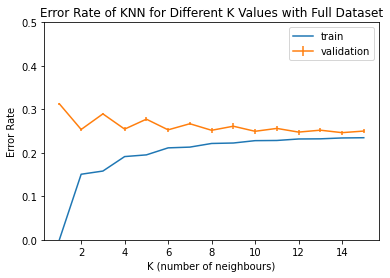

Best K parameter: 14


In [11]:
# knn cross-validation on full dataset
err_val_matrix, err_train_matrix = my_validation.knn_cross_validation(x_train, y_train, K_list, L, my_validation.error_rate)
err_val_means = np.mean(err_val_matrix, axis=1)

# Visualize
plt.title('Error Rate of KNN for Different K Values with Full Dataset')
plt.plot(K_list, np.mean(err_train_matrix, axis=1),  label='train')
plt.errorbar(K_list, err_val_means, np.std(err_val_matrix, axis=1), label='validation')
plt.legend()
plt.xlabel('K (number of neighbours)')
plt.ylabel('Error Rate')
plt.ylim(0,0.5)
plt.show()

# The best K parameter is the one providing the smallest error rate
best_k = K_list[np.argmin(err_val_means)]
print("Best K parameter: {k}".format(k=best_k))

#### Sample Growing Data

Observe the effect of growing the sample size on the training and validation errors.

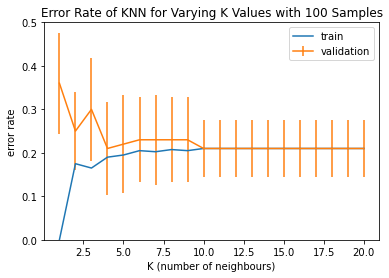

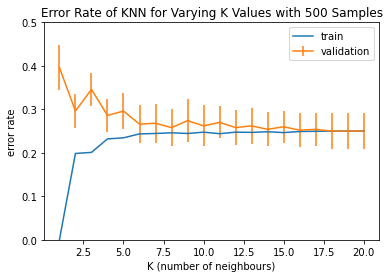

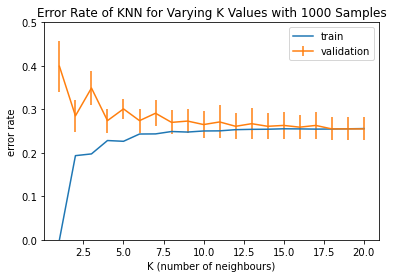

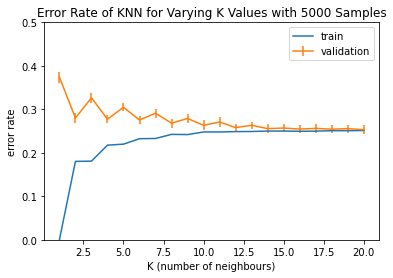

In [12]:
sizes = [100, 500, 1000, 5000]

# K range list
K_list = range(1,21)

for s in sizes:
    # select s random samples from train dataset
    x_subset, y_subset = x_train[inds[:s]], y_train[inds[:s]]
    
    # apply cross validation to get validation and train accuracy matrices 
    err_val_matrix, err_train_matrix = my_validation.knn_cross_validation(x_subset, y_subset, K_list, L, my_validation.error_rate)
    
    err_val_means = np.mean(err_val_matrix, axis=1)
    
    plt.title('Error Rate of KNN for Varying K Values with {size} Samples'.format(size = s))
    plt.plot(K_list, np.mean(err_train_matrix, axis=1),  label='train')
    plt.errorbar(K_list, err_val_means, np.std(err_val_matrix, axis=1), label='validation')
    plt.legend()
    plt.xlabel('K (number of neighbours)')
    plt.ylabel('error rate')
    plt.ylim(0,0.5)
    plt.show()

#### Use Best Parameter on Test Set

In [13]:
model = KNeighborsClassifier(n_neighbors=best_k)
start_time = time.time()
model.fit(x_train, y_train)
tr_time = time.time() - start_time

y_pred = model.predict(x_test)
pred_time = time.time() - tr_time

err_rate = my_validation.error_rate(y_test, y_pred)

print("Error Rate on Test Set: {err_rate}".format(err_rate=err_rate))
print("Training time: {tr_time}".format(tr_time=tr_time))
print("Prediction time: {pred_time}".format(pred_time=pred_time))

Error Rate on Test Set: 1.0
Training time: 0.238006591796875
Prediction time: 1632427392.1165879


### 2. DECISION-TREE

In [14]:
from sklearn.tree import DecisionTreeClassifier

# number of folds for L-fold cross-validation
L = 5

# Maximum tree depth hyper-parameter
max_d_list = list(range(1,16)) #1-15

#
min_samples_per_leaves_list = list(range(1,11)) #1-10\

#### Cross-Validation

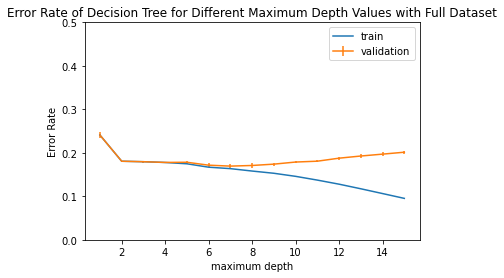

Best max depth parameter: 7


In [15]:
# decision tree cross-validation on full dataset
err_val_matrix, err_train_matrix = my_validation.dt_cross_validation(x_train, y_train, max_d_list, L, my_validation.error_rate)
err_val_means = np.mean(err_val_matrix, axis=1)

# Visualize
plt.title('Error Rate of Decision Tree for Different Maximum Depth Values with Full Dataset')
plt.plot(max_d_list, np.mean(err_train_matrix, axis=1),  label='train')
plt.errorbar(max_d_list, err_val_means, np.std(err_val_matrix, axis=1), label='validation')
plt.legend()
plt.xlabel('maximum depth')
plt.ylabel('Error Rate')
plt.ylim(0,0.5)
plt.show()

# The best K parameter is the one providing the smallest error rate
Best_max_depth = max_d_list[np.argmin(err_val_means)]
print("Best max depth parameter: {k}".format(k=Best_max_depth))

#### Sample Growing Data

Observe the effect of growing the sample size on the training and validation errors.

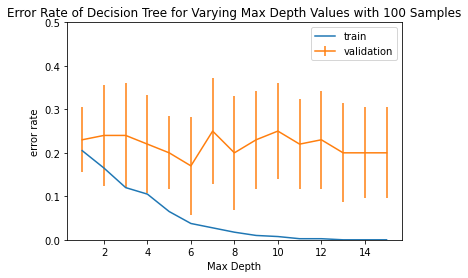

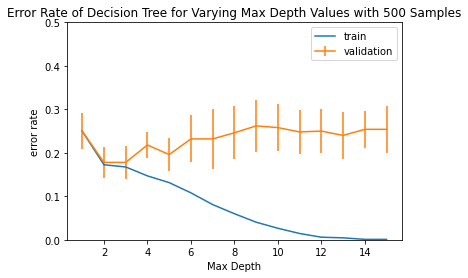

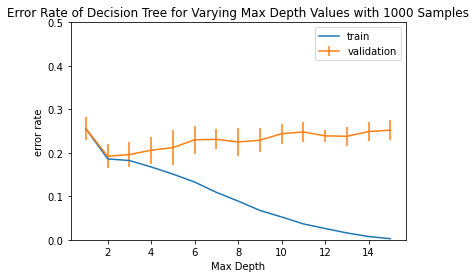

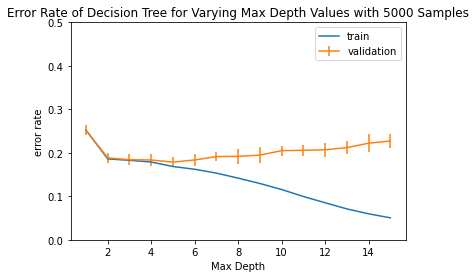

In [16]:
sizes = [100, 500, 1000, 5000]

# Max depth range list
max_d_list = range(1,16)

for s in sizes:
    # select s random samples from train dataset
    x_subset, y_subset = x_train[inds[:s]], y_train[inds[:s]]
    
    # apply cross validation to get validation and train accuracy matrices 
    err_val_matrix, err_train_matrix = my_validation.dt_cross_validation(x_subset, y_subset, max_d_list, L, my_validation.error_rate)
    
    err_val_means = np.mean(err_val_matrix, axis=1)
    
    plt.title('Error Rate of Decision Tree for Varying Max Depth Values with {size} Samples'.format(size = s))
    plt.plot(max_d_list, np.mean(err_train_matrix, axis=1),  label='train')
    plt.errorbar(max_d_list, err_val_means, np.std(err_val_matrix, axis=1), label='validation')
    plt.legend()
    plt.xlabel('Max Depth')
    plt.ylabel('error rate')
    plt.ylim(0,0.5)
    plt.show()

#### Use Best Parameter Combination on Test Set

In [20]:
model = DecisionTreeClassifier(max_depth=Best_max_depth)
start_time = time.time()
model.fit(x_train, y_train)
tr_time = time.time() - start_time

y_pred = model.predict(x_test)
pred_time = time.time() - tr_time

err_rate = my_validation.error_rate(y_test, y_pred)

print("Error Rate on Test Set: {err_rate}".format(err_rate=err_rate))
print("Training time: {tr_time}".format(tr_time=tr_time))
print("Prediction time: {pred_time}".format(pred_time=pred_time))

Error Rate on Test Set: 1.0
Training time: 0.15351223945617676
Prediction time: 1632427751.3230073
